In [1]:
import sys
import numpy as np
import nibabel as nib
import scipy.stats as stats
from scipy.linalg import pinv
import os

In [2]:
def load_ev_files(ev_list_file, n_timepoints, tr):
    with open(ev_list_file, 'r') as f:
        ev_files = [line.strip() for line in f if line.strip()]

    design_matrix = np.zeros((n_timepoints, len(ev_files)))

    for idx, ev_file in enumerate(ev_files):
        ev_data = np.loadtxt(ev_file)
        if ev_data.ndim == 1:
            ev_data = ev_data[np.newaxis, :]
        for start, duration, value in ev_data:
            onset_idx = int(start / tr)
            duration_idx = int(duration / tr)
            design_matrix[onset_idx:onset_idx+duration_idx, idx] = value

    return design_matrix, len(ev_files)


In [3]:
def load_contrasts(contrast_file, num_evs):
    contrasts = np.loadtxt(contrast_file)
    if contrasts.ndim == 1:
        contrasts = contrasts[np.newaxis, :]
    if contrasts.shape[1] != num_evs:
        raise ValueError(f"Contrast file has {contrasts.shape[1]} columns, but there are {num_evs} EVs.")
    return contrasts

In [4]:
def run_glm(Y, X):
    betas = pinv(X) @ Y
    Y_hat = X @ betas
    residuals = Y - Y_hat
    dof = X.shape[0] - X.shape[1]
    sigma_squared = np.sum(residuals**2, axis=0) / dof
    var_betas = sigma_squared * np.sum(pinv(X)**2, axis=1)[:, np.newaxis]
    return betas, var_betas, dof

In [5]:
def compute_contrast_stats(betas, var_betas, contrast, dof):
    contrast_val = contrast @ betas
    contrast_var = np.sum((contrast[:, np.newaxis]**2) * var_betas, axis=0)
    t_stat = contrast_val / np.sqrt(contrast_var)
    z_stat = stats.norm.ppf(stats.t.cdf(t_stat, dof))
    return contrast_val, t_stat, z_stat

In [6]:
# def save_nifti(data, ref_img, filename):
#     out_img = nib.Nifti1Image(data, affine=ref_img.affine, header=ref_img.header)
#     nib.save(out_img, filename)

def save_nifti(data, ref_img, filename):
    # Create a new NIfTI image with the same header as reference
    out_img = nib.Nifti1Image(data, affine=ref_img.affine, header=ref_img.header)
    
    # Ensure the data type matches FSL's expectations (usually float32)
    out_img.set_data_dtype(np.float32)
    
    # Update necessary header fields
    out_img.header['cal_min'] = np.min(data)
    out_img.header['cal_max'] = np.max(data)
    out_img.header['scl_slope'] = 1.0
    out_img.header['scl_inter'] = 0.0
    
    nib.save(out_img, filename)

In [9]:
def main():
    # if len(sys.argv) != 5:
    #     print("Usage: python glm.py <functional_file> <ev_file> <contrast_file> <output_prefix>")
    #     sys.exit(1)

    func_file = "../data/S01/raw_fMRI_raw_bold.nii.gz"
    ev_list_file = "EV_list.txt"
    contrast_file = "contrast.txt"
    out_prefix = "output"
    
    # Load 4D fMRI data
    func_img = nib.load(func_file)
    func_data = func_img.get_fdata()
    shape_3d = func_data.shape[:3]
    n_timepoints = func_data.shape[3]
    tr = func_img.header.get_zooms()[3]

    # Reshape fMRI data to (time, voxels)
    Y = func_data.reshape(-1, n_timepoints).T

    # Load design matrix and contrast
    X, num_evs = load_ev_files(ev_list_file, n_timepoints, tr)
    contrasts = load_contrasts(contrast_file, num_evs)

    # Fit GLM
    betas, var_betas, dof = run_glm(Y, X)

    # Save PE files (β)
    for i in range(num_evs):
        beta_map = betas[i, :].reshape(shape_3d)
        save_nifti(beta_map, func_img, f"Output/{out_prefix}.pe{i+1}.nii.gz")

    # Process each contrast
    for i, contrast in enumerate(contrasts):
        cope, tstat, zstat = compute_contrast_stats(betas, var_betas, contrast, dof)
        save_nifti(cope.reshape(shape_3d), func_img, f"Output/{out_prefix}.cope{i+1}.nii.gz")
        save_nifti(tstat.reshape(shape_3d), func_img, f"Output/{out_prefix}.tstat{i+1}.nii.gz")
        save_nifti(zstat.reshape(shape_3d), func_img, f"Output/{out_prefix}.zstat{i+1}.nii.gz")



In [10]:
if __name__ == "__main__":
    main()

C:\Users\ch720\AppData\Local\Temp\ipykernel_11424\149980109.py:4: RuntimeWarning: invalid value encountered in divide
  t_stat = contrast_val / np.sqrt(contrast_var)


In [25]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot_comparison(fsl_file, my_file, title, output_file):
    fsl_img = nib.load(fsl_file).get_fdata().flatten()
    my_img = nib.load(my_file).get_fdata().flatten()

    # Optional: mask out zeros or NaNs
    mask = (fsl_img != 0) & (my_img != 0) & ~np.isnan(fsl_img) & ~np.isnan(my_img)

    plt.figure(figsize=(6, 6))
    plt.scatter(fsl_img[mask], my_img[mask], s=1, alpha=0.3)
    # plt.scatter(fsl_img, my_img, s=4, alpha=1)
    plt.xlabel("FSL Values")
    plt.ylabel("Your Values")
    plt.title(title)
    plt.grid(True)
    plt.savefig(output_file)
    plt.show()


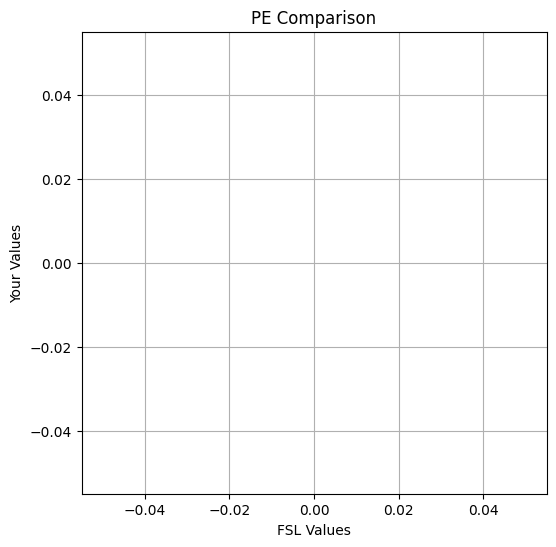

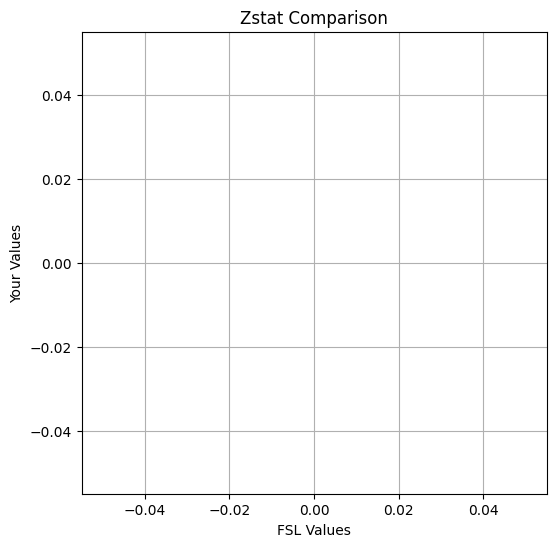

In [27]:
scatter_plot_comparison("A4/S02.feat/stats/pe3.nii.gz", "Output/output.pe3.nii.gz", 
                        "PE Comparison", "Output/pe_comparison.png")

scatter_plot_comparison("A4/S02.feat/stats/zstat3.nii.gz", "Output/output.zstat3.nii.gz", 
                        "Zstat Comparison", "Output/zstat_comparison.png")


In [29]:
def show_brain_maps(fsl_file, my_file, slice_index, title, output_file):
    fsl_img = nib.load(fsl_file).get_fdata()
    my_img = nib.load(my_file).get_fdata()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(np.rot90(fsl_img[:, :, slice_index]), cmap='hot')
    axes[0].set_title("FSL")
    axes[0].axis("off")

    axes[1].imshow(np.rot90(my_img[:, :, slice_index]), cmap='hot')
    axes[1].set_title("Your Tool")
    axes[1].axis("off")

    fig.suptitle(title)
    plt.savefig(output_file)
    plt.show()


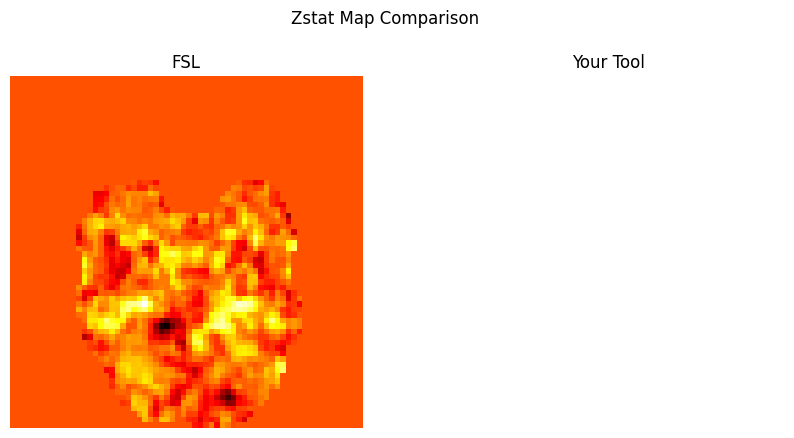

In [38]:
show_brain_maps("A4/S03.feat/stats/zstat3.nii.gz", "Output/output.zstat1.nii.gz", 
                slice_index=10, 
                title="Zstat Map Comparison", 
                output_file="zstat_map_side_by_side.png")
